# Ranking Performance Assessment

In this notebook, we have evaluated the "edge" provided by adding a Machine Learning method to the ranking step of this trading algorithm. We analyze the performance of:

* A classification model approach (which reduces to a filtering task)
* A time-series model approach
* A simplistic momentum strategy approach

Each of these approaches are benchmarked against an equally-weighted portfolio of all assets available in the given universe. The assets selected under each strategy are equally weighted to allow for equal comparison with the benchmark and across strategies.

In [1]:
%load_ext autoreload
%autoreload 2

# Analytics
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Utilities
import os
import joblib
from functools import reduce
from utils import *

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

In [2]:
data_path = os.path.dirname(os.getcwd()) + '/data'
data_prefix = '/broad_assets_'
test_path = data_path + '/classifier_test'
rets = pd.read_excel(data_path + data_prefix + 'weekly_rets.xlsx', index_col=0, parse_dates=True)
rets = rets.shift(-1)

# Classifier Models

## Loading features data and organizing by asset

We have calculated the features that will be fed to the classifier model in a separate file and pulled those features for each of the trading days. We load them here and re-organize the tables from being feature-focused to asset-focused.

In [3]:
# Load test data for portfolio evaluation
with open('classifier_features.txt', 'r') as f:
    features = [line.strip() for line in f]
# features = ['roc_4w', 'roc_6w', 'roc_12w', 'roc_26w', 'roc_52w', 'rsi', 'stoch_rsi', 'ewma_vol', 'skew', 'kurtosis', 
#             'macd_line', 'macd_signal', 'macd_histogram', 'ht_dcperiod', 'ht_dcphase', 'inphase', 'sine', 'ht_trendmode']

assets = ['Asset 1', 'Asset 2', 'Asset 3', 'Asset 4', 'Asset 5', 'Asset 6', 
          'Asset 7', 'Asset 8', 'Asset 9', 'Asset 10', 'Asset 11']
big_df = pd.DataFrame()
for feature in features:
    temp = pd.read_excel(test_path + data_prefix + feature + '_test.xlsx', sheet_name=0, index_col=0, parse_dates=True)
    temp_cols = [feature + '_' + asset for asset in assets]
    temp.columns = temp_cols
    big_df = pd.concat([big_df, temp], axis=1)

big_df

,roc_4w_Asset 1,roc_4w_Asset 2,roc_4w_Asset 3,roc_4w_Asset 4,roc_4w_Asset 5,roc_4w_Asset 6,roc_4w_Asset 7,roc_4w_Asset 8,roc_4w_Asset 9,roc_4w_Asset 10,...,ht_trendmode_lag12_Asset 2,ht_trendmode_lag12_Asset 3,ht_trendmode_lag12_Asset 4,ht_trendmode_lag12_Asset 5,ht_trendmode_lag12_Asset 6,ht_trendmode_lag12_Asset 7,ht_trendmode_lag12_Asset 8,ht_trendmode_lag12_Asset 9,ht_trendmode_lag12_Asset 10,ht_trendmode_lag12_Asset 11
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-27,0.1870,0.2387,-0.0270,-0.0052,0.1957,0.0707,0.0691,0.1341,0.0143,0.1109,...,1,1,1,1,1,1,1,1,1,1
2020-05-04,0.1320,0.1844,-0.0182,0.0042,0.2116,0.0984,0.0641,0.0362,-0.0273,0.0469,...,1,1,1,0,1,0,1,1,0,1
2020-05-11,0.1206,0.2359,-0.0372,0.0037,0.1727,-0.0497,0.0434,0.0607,0.0146,-0.0227,...,1,1,1,1,1,1,0,1,0,1
2020-05-18,0.0914,0.1370,-0.0782,-0.0117,0.1914,-0.0170,0.0661,0.0857,-0.0118,0.0418,...,0,1,1,0,1,1,1,1,1,1
2020-05-22,0.0534,0.1316,-0.0345,0.0040,0.1046,-0.0451,0.0322,0.0010,-0.0075,0.0226,...,1,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,-0.1393,-0.2418,0.1312,0.0630,-0.0111,0.1116,-0.0934,-0.1485,-0.0417,0.0376,...,1,0,1,1,1,1,1,0,0,1
2024-08-12,-0.1052,-0.1817,0.0831,0.0403,-0.1205,0.0532,-0.0700,-0.0890,-0.0180,0.0353,...,1,1,0,1,1,1,1,1,1,1
2024-08-19,0.0099,-0.0157,0.1147,0.0448,-0.0558,0.0498,0.0243,0.0262,-0.0442,0.0850,...,1,1,0,1,1,1,1,1,0,0


In [4]:
asset_dfs = {}
for asset in assets:
    asset_cols = [col for col in big_df.columns if asset in col]
    asset_dfs[asset] = big_df[asset_cols]

# Cleaning up Asset 1 DataFrame
asset_dfs['Asset 1'] = asset_dfs['Asset 1'].drop(columns=[col for col in asset_dfs['Asset 1'].columns if '10' in col])
asset_dfs['Asset 1'] = asset_dfs['Asset 1'].drop(columns=[col for col in asset_dfs['Asset 1'].columns if '11' in col])

In [5]:
# Checking that all dataframes have the same number of features to pass to model.
for asset in assets:
    print(len(asset_dfs[asset].columns))

270
270
270
270
270
270
270
270
270
270
270


In [6]:
# Cleanup column names to pass to classifier models
for name, frame in asset_dfs.items():
    frame.columns = [col.replace('_' + name, '') for col in frame.columns]

In [7]:
asset_dfs['Asset 1']

,roc_4w,roc_6w,roc_12w,roc_26w,roc_52w,rsi,rolling_vol_20,rolling_vol_60,rolling_vol_126,rolling_vol_252,...,bb_180d_upper_lag12,bb_180d_lower_lag12,bb_240d_sma_lag12,bb_240d_upper_lag12,bb_240d_lower_lag12,ht_dcperiod_lag12,ht_dcphase_lag12,inphase_lag12,sine_lag12,ht_trendmode_lag12
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-27,0.1870,0.4074,-0.2815,-0.1763,-0.1228,66.4231,0.0543,0.0788,0.0547,0.0406,...,0.0323,-0.0293,0.0014,0.0313,-0.0285,28.2630,214.8414,-0.1927,-0.5713,0
2020-05-04,0.1320,0.5730,-0.3428,-0.2179,-0.1393,50.3505,0.0491,0.0792,0.0551,0.0409,...,0.0329,-0.0288,0.0016,0.0319,-0.0286,24.4350,302.4536,-0.0744,-0.8438,1
2020-05-11,0.1206,0.2293,-0.3134,-0.1740,-0.0048,70.7707,0.0366,0.0794,0.0553,0.0409,...,0.0330,-0.0284,0.0017,0.0320,-0.0285,20.3095,124.5496,0.1614,0.8236,1
2020-05-18,0.0914,0.2223,-0.2338,-0.1804,-0.0101,58.7011,0.0350,0.0801,0.0558,0.0411,...,0.0332,-0.0301,0.0013,0.0327,-0.0300,17.6469,212.7406,0.0573,-0.5408,0
2020-05-22,0.0534,0.1399,-0.1599,-0.1855,0.0015,62.5326,0.0312,0.0786,0.0559,0.0411,...,0.0389,-0.0371,0.0009,0.0372,-0.0354,18.4343,314.6006,-0.2828,-0.7120,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,-0.1393,-0.1005,-0.0237,0.0777,0.2649,23.1997,0.0244,0.0165,0.0157,0.0154,...,0.0317,-0.0279,0.0018,0.0308,-0.0272,20.8615,149.0934,0.3461,0.5136,1
2024-08-12,-0.1052,-0.0546,0.0019,0.1081,0.3593,38.7241,0.0269,0.0175,0.0163,0.0156,...,0.0314,-0.0279,0.0018,0.0306,-0.0271,22.0819,174.5711,0.1519,0.0946,1
2024-08-19,0.0099,0.0048,0.1050,0.2273,0.5582,59.3434,0.0282,0.0186,0.0165,0.0158,...,0.0316,-0.0278,0.0016,0.0304,-0.0273,24.8076,184.7285,0.1959,-0.0824,1


## Generating Asset Selections and Equal-Weight Portfolio using Classifiers

We trained three different types of classifier models:

1. Decision Tree
1. Random Forest
1. XGBoost

For each model, we took a time-agnostic approach to organizing our training data. That is, instead of training the model on each asset independently, we expanded our training set by stacking each asset time-series on top of one another. We believe this approach is appropriate because classifier models are, by nature, time-agnostic. The models were trained to use the features to predict whether an asset with a given set of features would produce positive returns over the planned holding period (1-week for the broad asset universe). 

Below, we load the models we trained, generate the predictions over the test data set (data for which the models have not seen either during training or hyperparameter tuning), and then apply an equal-weighting methodology to the selected assets.

In [8]:
# Load the models
decision_tree = joblib.load('acc_decision_tree.joblib')
acc_random_forest = joblib.load('acc_random_forest_model.joblib')
f1_random_forest = joblib.load('f1_random_forest_model.joblib')
acc_xgb = joblib.load('acc_xgb_model.joblib')
f1_xgb = joblib.load('f1_xgb_model.joblib')

In [10]:
# Generate Predictions and add them to selections DataFrame
decision_tree_selections = pd.DataFrame(columns=assets, index=asset_dfs['Asset 1'].index)
acc_random_forest_selections = decision_tree_selections.copy()
f1_random_forest_selections = decision_tree_selections.copy()
acc_xgb_selections = decision_tree_selections.copy()
f1_xgb_selections = decision_tree_selections.copy()

for name, frame in asset_dfs.items():
    decision_tree_selections[name] = decision_tree.predict(frame)
    acc_random_forest_selections[name] = acc_random_forest.predict(frame)
    f1_random_forest_selections[name] = f1_random_forest.predict(frame)
    acc_xgb_selections[name] = acc_xgb.predict(frame)
    f1_xgb_selections[name] = f1_xgb.predict(frame)

In [11]:
display(decision_tree_selections)
display(acc_random_forest_selections)
display(f1_xgb_selections)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,1,1,1,1,1,1,1,1,1,1,1
2020-05-04,1,1,1,1,1,1,1,1,1,1,1
2020-05-11,1,1,1,1,1,1,1,1,1,1,1
2020-05-18,1,1,1,1,1,1,1,1,1,1,1
2020-05-22,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,1,1,1,1,1,1,1,1,1,1,1
2024-08-12,1,1,1,1,1,1,1,1,1,1,1
2024-08-19,1,1,1,1,1,1,1,1,1,1,1


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,1,1,1,1,0,0,1,1,1,1,0
2020-05-04,1,1,1,1,0,1,1,1,1,1,0
2020-05-11,0,0,1,1,1,0,1,1,1,1,0
2020-05-18,1,1,1,1,0,0,0,1,1,1,0
2020-05-22,1,1,1,1,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,1,1,1,1,1,1,1,1,1,1,1
2024-08-12,1,1,1,1,1,1,1,1,1,1,1
2024-08-19,1,1,1,1,1,1,1,1,1,1,1


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,1,1,1,1,1,1,1,1,1,1,1
2020-05-04,1,1,1,1,1,1,1,1,1,1,1
2020-05-11,1,1,1,1,1,1,1,1,1,1,1
2020-05-18,1,1,1,1,1,1,1,1,1,1,1
2020-05-22,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,1,1,1,1,1,1,1,1,1,1,1
2024-08-12,1,1,1,1,1,1,1,1,1,1,1
2024-08-19,1,1,1,1,1,1,1,1,1,1,1


In [25]:
decision_tree_counts = decision_tree_selections.sum(axis=1)
decision_tree_selections = decision_tree_selections.div(decision_tree_counts, axis=0)

acc_random_forest_counts = acc_random_forest_selections.sum(axis=1)
acc_random_forest_selections = acc_random_forest_selections.div(acc_random_forest_counts, axis=0)

f1_random_forest_counts = f1_random_forest_selections.sum(axis=1)
f1_random_forest_selections = f1_random_forest_selections.div(f1_random_forest_counts, axis=0)

acc_xgb_counts = acc_xgb_selections.sum(axis=1)
acc_xgb_selections = acc_xgb_selections.div(acc_xgb_counts, axis=0)

f1_xgb_counts = f1_xgb_selections.sum(axis=1)
f1_xgb_selections = f1_xgb_selections.div(f1_xgb_counts, axis=0)

display(decision_tree_selections)
display(acc_random_forest_selections)
display(f1_xgb_selections)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2020-05-04,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2020-05-11,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2020-05-18,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2020-05-22,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2024-08-12,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2024-08-19,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,0.1250,0.1250,0.1250,0.1250,NaN,NaN,0.1250,0.1250,0.1250,0.1250,NaN
2020-05-04,0.1111,0.1111,0.1111,0.1111,NaN,0.1111,0.1111,0.1111,0.1111,0.1111,NaN
2020-05-11,NaN,NaN,0.1429,0.1429,0.1429,NaN,0.1429,0.1429,0.1429,0.1429,NaN
2020-05-18,0.1429,0.1429,0.1429,0.1429,NaN,NaN,NaN,0.1429,0.1429,0.1429,NaN
2020-05-22,0.1111,0.1111,0.1111,0.1111,0.1111,NaN,0.1111,0.1111,0.1111,0.1111,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2024-08-12,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2024-08-19,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2020-05-04,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2020-05-11,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2020-05-18,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2020-05-22,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2024-08-12,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909
2024-08-19,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909


In [26]:
eval_rets = rets.loc[f1_xgb_selections.index]
eval_rets

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,-0.0260,-0.0034,-0.0101,0.0029,-0.0328,-0.0515,-0.0157,-0.0356,-0.0126,-0.0143,0.0372
2020-05-04,0.0632,0.1084,-0.0579,-0.0060,0.0914,0.0207,0.0369,0.0504,0.0133,-0.0055,0.0374
2020-05-11,0.0156,0.0063,0.0036,-0.0010,0.0138,-0.0328,0.0193,0.0446,-0.0120,0.0409,0.0786
2020-05-18,0.0016,0.0179,0.0316,0.0081,0.0321,0.0198,-0.0077,-0.0541,0.0040,0.0022,-0.0004
2020-05-22,0.0693,0.0396,-0.0333,0.0020,0.0729,0.1504,0.1502,0.1211,-0.0414,0.0052,0.0444
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0.0607,0.0718,-0.0440,-0.0147,0.0210,0.0425,0.0431,0.0882,0.0093,0.0503,0.0583
2024-08-12,0.1006,0.1346,0.0199,-0.0004,0.1037,0.0321,0.0931,0.0771,-0.0238,0.0239,-0.0377
2024-08-19,0.0020,-0.0266,0.0028,0.0064,0.0450,0.0540,0.0290,-0.0180,-0.0195,0.0097,0.0332


In [27]:
# Preliminary portfolio summaries to ensure consistency
decision_tree_rets = (eval_rets * decision_tree_selections).sum(axis=1).to_frame('Decision Tree Portfolio Returns')
acc_random_forest_rets = (eval_rets * acc_random_forest_selections).sum(axis=1).to_frame('Accuracy-Tuned Random Forest Portfolio Returns')
f1_random_forest_rets = (eval_rets * f1_random_forest_selections).sum(axis=1).to_frame('F1-Tuned Random Forest Portfolio Returns')
acc_xgb_rets = (eval_rets * acc_xgb_selections).sum(axis=1).to_frame('Accuracy-Tuned XGB Portfolio Returns')
f1_xgb_rets = (eval_rets * f1_xgb_selections).sum(axis=1).to_frame('F1-Tuned XGB Portfolio Returns')

classifier_rets = pd.concat([decision_tree_rets, acc_random_forest_rets, f1_random_forest_rets, acc_xgb_rets, f1_xgb_rets], axis=1)
classifier_rets.describe()

,Decision Tree Portfolio Returns,Accuracy-Tuned Random Forest Portfolio Returns,F1-Tuned Random Forest Portfolio Returns,Accuracy-Tuned XGB Portfolio Returns,F1-Tuned XGB Portfolio Returns
count,228.0000,228.0000,228.0000,228.0000,228.0000
mean,0.0032,0.0034,0.0032,0.0032,0.0032
std,0.0290,0.0280,0.0286,0.0290,0.0290
min,-0.1040,-0.1006,-0.1040,-0.1040,-0.1040
25%,-0.0132,-0.0127,-0.0127,-0.0132,-0.0132
50%,0.0031,0.0031,0.0031,0.0031,0.0031
75%,0.0209,0.0207,0.0209,0.0209,0.0209
max,0.0770,0.0770,0.0770,0.0770,0.0770


# Time Series Model

In [16]:
ARIMA_prediction = pd.read_csv('ARIMA_prediction.csv')
ARIMA_prediction.set_index('Date', inplace = True)

FileNotFoundError: [Errno 2] No such file or directory: 'ARIMA_prediction.csv'

### Turn into weekly data

In [8]:
ARIMA_prediction.index = pd.to_datetime(ARIMA_prediction.index)
ARIMA_prediction['weekday'] = ARIMA_prediction.index.day_name()
ARIMA_prediction.head()

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11,weekday
Date,,,,,,,,,,,,
2019-11-18,0.0012,0.0013,0.0007,0.0002,0.0013,0.0016,0.0008,0.0006,0.0002,0.0005,0.0002,Monday
2019-11-19,0.0006,0.0013,0.0005,0.0002,0.0006,0.0001,0.0001,0.0006,0.0005,0.0004,0.0003,Tuesday
2019-11-20,0.0012,0.0013,0.0005,0.0002,0.0009,0.0015,0.0008,0.0006,0.0002,0.0004,0.0004,Wednesday
2019-11-21,0.0007,0.0013,0.0005,0.0002,0.0006,0.0002,0.0001,0.0006,0.0005,0.0004,0.0003,Thursday
2019-11-22,0.0012,0.0013,0.0005,0.0002,0.0009,0.0014,0.0008,0.0006,0.0002,0.0004,0.0003,Friday


In [10]:
ARIMA_prediction['trading_day'] = np.where((ARIMA_prediction.weekday == 'Tuesday'), 1, 0)   # Start of return calc periods are typically Tuesday
ARIMA_prediction['trading_day'] = np.where((ARIMA_prediction.weekday == 'Wednesday') & 
                                       (ARIMA_prediction.weekday.shift(1) == 'Monday'), 
                                       1, ARIMA_prediction.trading_day) # This filter sets Wednesday as the first trading day when Tuesday is a holiday
ARIMA_prediction['trading_day'] = np.where((ARIMA_prediction.weekday == 'Wednesday') & 
                                       (ARIMA_prediction.weekday.shift(1) == 'Friday'), 
                                       1, ARIMA_prediction.trading_day) # There are a few cases where markets were shut down both Monday and Tuesday
# The 9/11 Terrorist attacks were on a Tuesday and shut down markets for a week. Markets re-opened on 9/17, so assuming we place trades 
# that day and calculate returns through the following EOD Monday. This is the longest holding window in the dataset.
# TODO: Question, should we just drop 9/17/2001 from the dataset?
ARIMA_prediction['trading_day'] = np.where(ARIMA_prediction.index == '2001-09-17', 1, ARIMA_prediction.trading_day)
ARIMA_prediction['trading_day'] = np.where(ARIMA_prediction.index == '2001-09-18', 0, ARIMA_prediction.trading_day)
ARIMA_prediction['week'] = ARIMA_prediction.trading_day.cumsum()
ARIMA_prediction

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11,weekday,trading_day,week
Date,,,,,,,,,,,,,,
2019-11-18,0.0012,0.0013,0.0007,0.0002,0.0013,0.0016,0.0008,0.0006,0.0002,0.0005,0.0002,Monday,0,0
2019-11-19,0.0006,0.0013,0.0005,0.0002,0.0006,0.0001,0.0001,0.0006,0.0005,0.0004,0.0003,Tuesday,1,1
2019-11-20,0.0012,0.0013,0.0005,0.0002,0.0009,0.0015,0.0008,0.0006,0.0002,0.0004,0.0004,Wednesday,0,1
2019-11-21,0.0007,0.0013,0.0005,0.0002,0.0006,0.0002,0.0001,0.0006,0.0005,0.0004,0.0003,Thursday,0,1
2019-11-22,0.0012,0.0013,0.0005,0.0002,0.0009,0.0014,0.0008,0.0006,0.0002,0.0004,0.0003,Friday,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,0.0010,0.0014,0.0008,-0.0001,-0.0052,-0.0001,0.0006,0.0005,-0.0006,0.0013,-0.0005,Friday,0,250
2024-09-03,0.0010,0.0014,-0.0008,-0.0001,0.0013,0.0014,0.0006,0.0005,-0.0002,0.0005,0.0002,Tuesday,1,251
2024-09-04,0.0010,0.0014,-0.0003,-0.0001,0.0008,-0.0000,0.0006,0.0005,-0.0006,0.0009,0.0008,Wednesday,0,251


In [12]:
ARIMA_weekly_rets = weekly_returns(ARIMA_prediction)
display(ARIMA_weekly_rets)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2019-11-18,0.0012,0.0013,0.0007,0.0002,0.0013,0.0016,0.0008,0.0006,0.0002,0.0005,0.0002
2019-11-25,0.0045,0.0064,0.0025,0.0010,0.0042,0.0040,0.0019,0.0030,0.0019,0.0018,0.0026
2019-12-02,0.0038,0.0053,0.0021,0.0009,0.0029,0.0036,0.0018,0.0024,0.0011,0.0016,0.0005
2019-12-09,0.0047,0.0067,0.0025,0.0012,0.0013,0.0040,0.0023,0.0030,0.0018,0.0022,0.0022
2019-12-16,0.0047,0.0066,0.0014,0.0013,0.0043,0.0035,0.0020,0.0029,0.0011,0.0017,0.0003
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.0048,0.0070,-0.0058,-0.0008,0.0102,0.0025,0.0028,0.0024,-0.0010,0.0041,0.0020
2024-08-19,0.0048,0.0068,0.0017,-0.0005,0.0043,0.0038,0.0027,0.0024,-0.0009,0.0032,0.0007
2024-08-26,0.0048,0.0070,0.0057,-0.0007,0.0033,0.0070,0.0028,0.0025,0.0001,0.0029,0.0002


In [15]:
ARIMA_weekly_rets['equal_weights'] = ARIMA_weekly_rets.mean(axis=1)
ARIMA_weekly_rets

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11,equal_weights
Date,,,,,,,,,,,,
2019-11-18,0.0012,0.0013,0.0007,0.0002,0.0013,0.0016,0.0008,0.0006,0.0002,0.0005,0.0002,0.0008
2019-11-25,0.0045,0.0064,0.0025,0.0010,0.0042,0.0040,0.0019,0.0030,0.0019,0.0018,0.0026,0.0031
2019-12-02,0.0038,0.0053,0.0021,0.0009,0.0029,0.0036,0.0018,0.0024,0.0011,0.0016,0.0005,0.0024
2019-12-09,0.0047,0.0067,0.0025,0.0012,0.0013,0.0040,0.0023,0.0030,0.0018,0.0022,0.0022,0.0029
2019-12-16,0.0047,0.0066,0.0014,0.0013,0.0043,0.0035,0.0020,0.0029,0.0011,0.0017,0.0003,0.0027
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.0048,0.0070,-0.0058,-0.0008,0.0102,0.0025,0.0028,0.0024,-0.0010,0.0041,0.0020,0.0026
2024-08-19,0.0048,0.0068,0.0017,-0.0005,0.0043,0.0038,0.0027,0.0024,-0.0009,0.0032,0.0007,0.0026
2024-08-26,0.0048,0.0070,0.0057,-0.0007,0.0033,0.0070,0.0028,0.0025,0.0001,0.0029,0.0002,0.0032


### Summary of Statistics

In [16]:
calc_summary_statistics(ARIMA_weekly_rets, annual_factor=52, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T

Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11,equal_weights
Annualized Mean,0.2516,0.3509,0.0325,-0.0142,0.2066,0.1555,0.1338,0.1565,0.0669,0.1416,0.0912,0.1430
Annualized Vol,0.0094,0.0079,0.0203,0.0223,0.0248,0.0353,0.0102,0.0065,0.0243,0.0064,0.0134,0.0083
Min,-0.0031,0.0013,-0.0071,-0.0231,-0.0131,-0.0238,-0.0095,0.0006,-0.0083,-0.0003,-0.0051,-0.0024
Max,0.0095,0.0089,0.0070,0.0277,0.0247,0.0168,0.0093,0.0051,0.0281,0.0053,0.0086,0.0061
Skewness,-0.8650,-0.5025,-0.1638,1.1740,0.6632,-1.3148,-2.6586,0.3982,3.8700,0.1962,0.1786,-0.3548
Excess Kurtosis,7.1587,1.5119,-0.5602,38.7793,7.3165,6.9288,24.6504,-0.8585,28.2469,0.4398,3.6036,1.4980
Historical VaR (5.00%),0.0034,0.0051,-0.0040,-0.0026,-0.0008,-0.0051,0.0009,0.0018,-0.0034,0.0014,-0.0006,0.0009
Annualized Historical VaR (5.00%),0.0242,0.0369,-0.0289,-0.0191,-0.0057,-0.0364,0.0063,0.0133,-0.0242,0.0099,-0.0040,0.0067
Historical CVaR (5.00%),0.0019,0.0044,-0.0050,-0.0066,-0.0028,-0.0099,-0.0010,0.0016,-0.0048,0.0010,-0.0027,0.0002
Annualized Historical CVaR (5.00%),0.0138,0.0317,-0.0358,-0.0476,-0.0202,-0.0712,-0.0073,0.0118,-0.0344,0.0069,-0.0191,0.0012


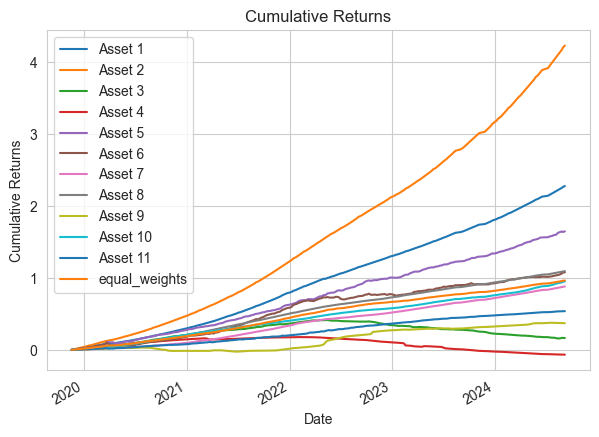

In [17]:
calc_cumulative_returns(ARIMA_weekly_rets)

# Benchmarks - Equal Weight Portfolio and Simple Momentum

We provide a portfolio that is equally weighted across all available assets in the investible universe to serve as a benchmark to the classifier model strategies' returns.

## Equal-Weights Portfolio

In [16]:
equal_rets = (eval_rets * 1/len(eval_rets.columns)).sum(axis=1).to_frame('Equal Weight Portfolio Return')
equal_rets.describe()

,Equal Weight Portfolio Return
count,228.0000
mean,0.0032
std,0.0290
min,-0.1040
25%,-0.0132
50%,0.0031
75%,0.0209
max,0.0770


## Simple Momentum Portfolio

For the simple momentum benchmarks, we take a few naive approaches:

1. We look at the prior holding period's return of a given asset
1. We look at the trailing 1-month return of a given asset
1. We look at the trailing 3-month return of a given asset
1. We look at the trailing 1-year return of a given asset

If that return was positive, we select it for investment in the following period. Otherwise, it is excluded from the portfolio. With these selections in hand, we equally-weight the investments.

**Note:** At this time, we are not making a weighted decision with respect to results from each momentum metric.

In [19]:
lag1_selections = pd.DataFrame(np.where(rets.shift(1) > 0, 1, 0), columns=rets.columns, index=rets.index)
lag1_selections = lag1_selections.loc[f1_xgb_selections.index]

lag4 = rets.rolling(window=4).apply(lambda x: np.prod(1 + x) - 1, raw=False)
lag4_selections = pd.DataFrame(np.where(lag4.shift(1) > 0, 1, 0), columns=rets.columns, index=rets.index)
lag4_selections = lag4_selections.loc[f1_xgb_selections.index]

lag12 = rets.rolling(window=12).apply(lambda x: np.prod(1 + x) - 1, raw=False)
lag12_selections = pd.DataFrame(np.where(lag12.shift(1) > 0, 1, 0), columns=rets.columns, index=rets.index)
lag12_selections = lag12_selections.loc[f1_xgb_selections.index]

lag52 = rets.rolling(window=52).apply(lambda x: np.prod(1 + x) - 1, raw=False)
lag52_selections = pd.DataFrame(np.where(lag52.shift(1) > 0, 1, 0), columns=rets.columns, index=rets.index)
lag52_selections = lag52_selections.loc[f1_xgb_selections.index]

display(lag1_selections)
display(lag4_selections)
display(lag12_selections)
display(lag52_selections)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,1,1,0,0,1,1,1,1,0,1,0
2020-05-04,0,0,0,1,0,0,0,0,0,0,1
2020-05-11,1,1,0,0,1,1,1,1,1,0,1
2020-05-18,1,1,1,0,1,0,1,1,0,1,1
2020-05-22,1,1,1,1,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0,0,1,1,0,0,0,0,0,1,0
2024-08-12,1,1,0,0,1,1,1,1,1,1,1
2024-08-19,1,1,1,0,1,1,1,1,0,1,0


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,1,1,0,0,1,1,1,1,1,1,0
2020-05-04,1,1,0,1,1,1,1,1,0,1,0
2020-05-11,1,1,0,1,1,0,1,1,1,0,0
2020-05-18,1,1,0,0,1,0,1,1,0,1,1
2020-05-22,1,1,0,1,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0,0,1,1,0,1,0,0,0,1,0
2024-08-12,0,0,1,1,0,1,0,0,0,1,0
2024-08-19,1,0,1,1,0,1,1,1,0,1,0


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,0,0,1,1,0,0,0,0,1,1,0
2020-05-04,0,0,1,1,0,0,0,0,1,1,0
2020-05-11,0,0,1,1,0,0,0,0,1,1,0
2020-05-18,0,0,1,1,0,0,0,0,1,1,0
2020-05-22,0,1,1,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0,0,1,1,0,1,0,0,0,1,0
2024-08-12,1,0,1,1,0,1,0,0,0,1,0
2024-08-19,1,1,1,1,1,1,1,1,0,1,0


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,0,1,1,1,0,0,0,0,1,1,0
2020-05-04,0,1,1,1,0,0,0,0,1,1,0
2020-05-11,0,1,1,1,0,0,0,0,1,1,0
2020-05-18,0,1,1,1,0,0,0,0,1,1,0
2020-05-22,1,1,1,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,1,1,1,1,1,1,1,0,1,1,0
2024-08-12,1,1,1,1,1,1,1,1,1,1,0
2024-08-19,1,1,1,1,1,1,1,1,1,1,0


In [20]:
lag1_counts = lag1_selections.sum(axis=1)
lag1_selections = lag1_selections.div(lag1_counts, axis=0)

lag4_counts = lag4_selections.sum(axis=1)
lag4_selections = lag4_selections.div(lag4_counts, axis=0)

lag12_counts = lag12_selections.sum(axis=1)
lag12_selections = lag12_selections.div(lag12_counts, axis=0)

lag52_counts = lag52_selections.sum(axis=1)
lag52_selections = lag52_selections.div(lag52_counts, axis=0)

display(lag1_selections)
display(lag4_selections)
display(lag12_selections)
display(lag52_selections)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,0.1429,0.1429,0.0000,0.0000,0.1429,0.1429,0.1429,0.1429,0.0000,0.1429,0.0000
2020-05-04,0.0000,0.0000,0.0000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000
2020-05-11,0.1250,0.1250,0.0000,0.0000,0.1250,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250
2020-05-18,0.1250,0.1250,0.1250,0.0000,0.1250,0.0000,0.1250,0.1250,0.0000,0.1250,0.1250
2020-05-22,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.0000,0.0000,0.1250,0.1250,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0.0000,0.0000,0.3333,0.3333,0.0000,0.0000,0.0000,0.0000,0.0000,0.3333,0.0000
2024-08-12,0.1111,0.1111,0.0000,0.0000,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
2024-08-19,0.1250,0.1250,0.1250,0.0000,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.0000


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,0.1250,0.1250,0.0000,0.0000,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.0000
2020-05-04,0.1250,0.1250,0.0000,0.1250,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.0000
2020-05-11,0.1429,0.1429,0.0000,0.1429,0.1429,0.0000,0.1429,0.1429,0.1429,0.0000,0.0000
2020-05-18,0.1429,0.1429,0.0000,0.0000,0.1429,0.0000,0.1429,0.1429,0.0000,0.1429,0.1429
2020-05-22,0.1250,0.1250,0.0000,0.1250,0.1250,0.0000,0.1250,0.1250,0.0000,0.1250,0.1250
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0.0000,0.0000,0.2500,0.2500,0.0000,0.2500,0.0000,0.0000,0.0000,0.2500,0.0000
2024-08-12,0.0000,0.0000,0.2500,0.2500,0.0000,0.2500,0.0000,0.0000,0.0000,0.2500,0.0000
2024-08-19,0.1429,0.0000,0.1429,0.1429,0.0000,0.1429,0.1429,0.1429,0.0000,0.1429,0.0000


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,0.0000,0.0000,0.2500,0.2500,0.0000,0.0000,0.0000,0.0000,0.2500,0.2500,0.0000
2020-05-04,0.0000,0.0000,0.2500,0.2500,0.0000,0.0000,0.0000,0.0000,0.2500,0.2500,0.0000
2020-05-11,0.0000,0.0000,0.2500,0.2500,0.0000,0.0000,0.0000,0.0000,0.2500,0.2500,0.0000
2020-05-18,0.0000,0.0000,0.2500,0.2500,0.0000,0.0000,0.0000,0.0000,0.2500,0.2500,0.0000
2020-05-22,0.0000,0.2000,0.2000,0.2000,0.0000,0.0000,0.0000,0.0000,0.2000,0.2000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0.0000,0.0000,0.2500,0.2500,0.0000,0.2500,0.0000,0.0000,0.0000,0.2500,0.0000
2024-08-12,0.2000,0.0000,0.2000,0.2000,0.0000,0.2000,0.0000,0.0000,0.0000,0.2000,0.0000
2024-08-19,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.0000,0.1111,0.0000


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-04-27,0.0000,0.2000,0.2000,0.2000,0.0000,0.0000,0.0000,0.0000,0.2000,0.2000,0.0000
2020-05-04,0.0000,0.2000,0.2000,0.2000,0.0000,0.0000,0.0000,0.0000,0.2000,0.2000,0.0000
2020-05-11,0.0000,0.2000,0.2000,0.2000,0.0000,0.0000,0.0000,0.0000,0.2000,0.2000,0.0000
2020-05-18,0.0000,0.2000,0.2000,0.2000,0.0000,0.0000,0.0000,0.0000,0.2000,0.2000,0.0000
2020-05-22,0.1667,0.1667,0.1667,0.1667,0.0000,0.0000,0.0000,0.0000,0.1667,0.1667,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.0000,0.1111,0.1111,0.0000
2024-08-12,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.0000
2024-08-19,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.0000


In [21]:
# Preliminary portfolio summaries to ensure consistency
lag1_rets = (eval_rets * lag1_selections).sum(axis=1).to_frame('1-Period Momentum Portfolio')
lag4_rets = (eval_rets * lag4_selections).sum(axis=1).to_frame('1-Month Momentum Portfolio')
lag12_rets = (eval_rets * lag12_selections).sum(axis=1).to_frame('3-Month Momentum Portfolio')
lag52_rets = (eval_rets * lag52_selections).sum(axis=1).to_frame('1-Year Momentum Portfolio')

benchmark_rets = pd.concat([equal_rets, lag1_rets, lag4_rets, lag12_rets, lag52_rets], axis=1)
benchmark_rets.describe()

,Equal Weight Portfolio Return,1-Period Momentum Portfolio,1-Month Momentum Portfolio,3-Month Momentum Portfolio,1-Year Momentum Portfolio
count,228.0000,228.0000,228.0000,228.0000,228.0000
mean,0.0032,0.0021,0.0032,0.0027,0.0021
std,0.0290,0.0294,0.0301,0.0315,0.0286
min,-0.1040,-0.0945,-0.1298,-0.0873,-0.0729
25%,-0.0132,-0.0165,-0.0123,-0.0177,-0.0172
50%,0.0031,0.0034,0.0037,0.0025,0.0036
75%,0.0209,0.0189,0.0199,0.0212,0.0196
max,0.0770,0.1077,0.0978,0.1616,0.0853


# Performance Evaluation

In [28]:
all_rets = pd.concat([benchmark_rets, classifier_rets], axis=1)
calc_summary_statistics(all_rets, annual_factor=52, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T

Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Equal Weight Portfolio Return,1-Period Momentum Portfolio,1-Month Momentum Portfolio,3-Month Momentum Portfolio,1-Year Momentum Portfolio,Decision Tree Portfolio Returns,Accuracy-Tuned Random Forest Portfolio Returns,F1-Tuned Random Forest Portfolio Returns,Accuracy-Tuned XGB Portfolio Returns,F1-Tuned XGB Portfolio Returns
Annualized Mean,0.1648,0.1086,0.1640,0.1397,0.1118,0.1658,0.1746,0.1678,0.1648,0.1648
Annualized Vol,0.2095,0.2119,0.2168,0.2272,0.2060,0.2094,0.2022,0.2062,0.2095,0.2095
Min,-0.1040,-0.0945,-0.1298,-0.0873,-0.0729,-0.1040,-0.1006,-0.1040,-0.1040,-0.1040
Max,0.0770,0.1077,0.0978,0.1616,0.0853,0.0770,0.0770,0.0770,0.0770,0.0770
Skewness,-0.3082,-0.1382,-0.3404,0.4204,0.0004,-0.3101,-0.2921,-0.3614,-0.3082,-0.3082
Excess Kurtosis,0.9712,1.2664,2.2962,2.4333,0.1621,0.9765,0.7956,1.0800,0.9712,0.9712
Historical VaR (5.00%),-0.0416,-0.0520,-0.0430,-0.0464,-0.0472,-0.0416,-0.0404,-0.0404,-0.0416,-0.0416
Annualized Historical VaR (5.00%),-0.3003,-0.3747,-0.3103,-0.3343,-0.3400,-0.3003,-0.2912,-0.2912,-0.3003,-0.3003
Historical CVaR (5.00%),-0.0609,-0.0655,-0.0675,-0.0619,-0.0565,-0.0609,-0.0586,-0.0606,-0.0609,-0.0609
Annualized Historical CVaR (5.00%),-0.4390,-0.4727,-0.4869,-0.4461,-0.4073,-0.4390,-0.4227,-0.4368,-0.4390,-0.4390


As we can see in this performance summary table, the classifier models outperform the benchmarks on just about every metric.

* **Annualized Mean Returns:** The classifier models realize 10x the annualized returns over the benchmark strategies.

* **Max and Min Period Returns:** The classifier strategies pick the outperforming portfolios throughout the observation period with respect to all benchmarks except the 3-month lookback momentum strategy. Additionally, the minimum return periods are all significantly smaller than all benchmark strategies. These stats highlight the selection power of these models.

* **Volatility and Value-At-Risk:** The classifier-driven strategies reduce volatility and significantly lower Value-At-Risk throughout the observation period. Though we note that Value-At-Risk is a questionable metric to report in this context as we are dynamically selecting securities in each portfolio.

* **Skewness & Kurtosis:** The classifier strategies produce return distributions with significantly greater positive skew compared to most of the benchmark strategies. Notably, the 1-month and 3-month lookback periods provide a reasonably strong positive skew in returns.

* **Max Drawdown:** The max drawdown realized across any of the classifier-based strategies is -1.5%. The best performing classifier, XGBoost, only has a maximum drawdown of -1.35%

**Note:** The current performance evaluation does not capture intra-week volatility (i.e: Day-to-day volatility). Will need to update this summary to capture that.

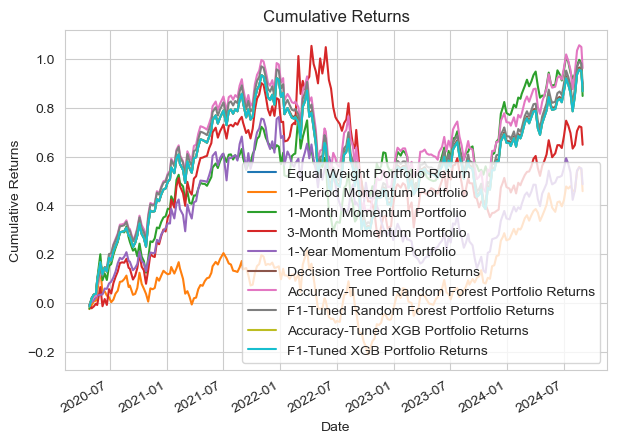

In [29]:
calc_cumulative_returns(all_rets)

The cumulative returns of the classifier model-based strategies dwarf the cumulative returns of the benchmark models. To provide a better visual comparison, we split out the two groups of cumulative returns below.

None

None

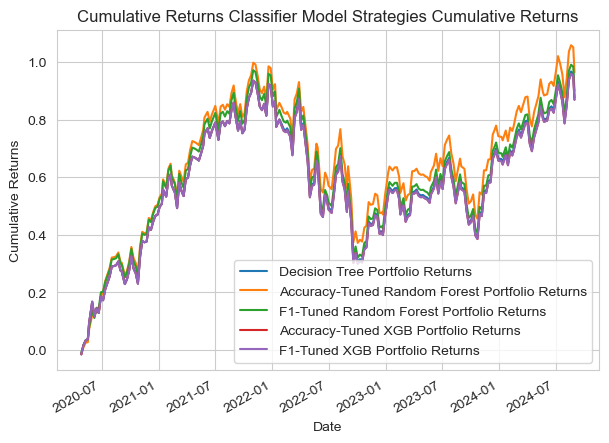

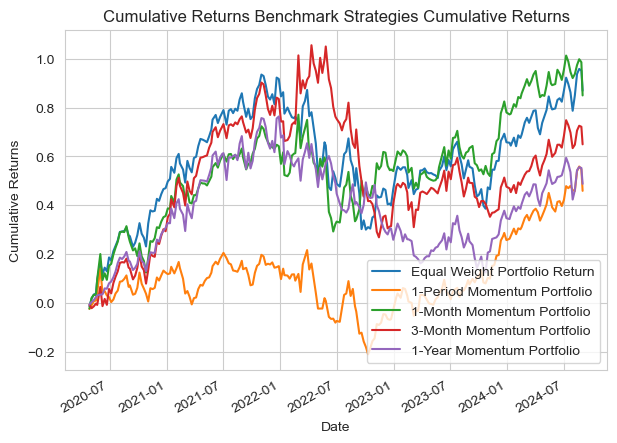

In [30]:
display(calc_cumulative_returns(classifier_rets, name='Classifier Model Strategies Cumulative Returns'), 
        calc_cumulative_returns(benchmark_rets, name='Benchmark Strategies Cumulative Returns'))